In [1]:
from LABNET import Neuron, Net, Lab, Teacher, compare_rows

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [3]:
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.min_weight_full_bipartite_matching.html
##look into this, its for graphs, maybe overkill
import torch
x = torch.tensor([[1,2,3,4],[5,5,2,2],[6,1,2,1],[3,1,5,1]])
permutation = torch.randperm(4)

# Shuffle the rows of the tensor using the permutation indices
y = x[permutation]
y[2,2] = 1
compare_rows(x,y)

##failing: if the same row is best for 2 rows in the target? not sure that ruins anything tho

(array([[4.24264069, 6.        , 5.74456265, 0.        ],
        [5.47722558, 4.24264069, 1.        , 5.47722558],
        [4.24264069, 0.        , 4.35889894, 6.        ],
        [0.        , 4.24264069, 6.08276253, 4.24264069]]),
 1.0)

In [ ]:
x = np.random.rand(5,5)
y = np.random.rand(5,5)
compare_rows(x,y)


## Make Teacher object in LABNET, make functions below methods ##



make a network with the same number of inputs as outputs.  then, add lots of hidden layers that are the same size.  see which layers are getting the most gradient.  by sum of absolute error.  then graph all layers together, the compounding gradient as it accumulates backwards through time should cause the earliest layers to vanish or explode.  its always happening.  we are never exactly zero on that dial.  how to straighten out that line? this might actually be a sound theory.  

theory i guess:gradient explosion or collapse is a spectrum.  first, is it normally distributed? i think its distribution is a function of the architecture, the depth and the number of neurons.  depth contribution makes the most sense.  you need all the deep layers to compound to get either issue.  as you get deeper, the risk of catastrophic gradient deviation increases, or, if we think about training lots of neural networks, or just the same neural network multiple times, it likely does that in some distribution.  so, we should either see the earliest layers train first if the gradient explodes, or the latter layers to train first (if vanish or collapse).   however, it looks like it does one or the other and runs into a minima. a decent minima even.  what would that mean.  it means on the loss landscape there may be lots of really decent places for the weights to end up, even if it doesn't match the ideal (controlled generated) weights.  
WHAT IF SOME INDIVIDUAL VALUES INSIDE WEIGHT MATRICES (i need a name for not a neuron, but an individual weight inside that tensor)

so, look at lots of em, see if there is evidence for that.  

then, is there a way to cut the compounding during the backward pass.  what if each layer only takes into account the next weight layer, doesnt' back propagate all the way back.  does that make it so each neuron can pull its weight?

In [4]:
def plot_line_graph(numbers
                    ,window_size = 1
                    ,plot_size = (10,6)
                    ,x_range = (None, None)
                    ,y_range = (None, None)
                   ):
    
    if window_size <= 0 or window_size > len(numbers):
        raise ValueError("Invalid window size")
    
    running_sum = sum(numbers[:window_size])
    averages = [running_sum / window_size]

    for i in range(window_size, len(numbers)):
        running_sum += numbers[i] - numbers[i - window_size]
        averages.append(running_sum / window_size)
    
    
    
    x = range(1, len(averages) + 1)  
    y = averages  # y-axis values
    plt.figure(figsize=plot_size)
    plt.plot(x, y)  # Plotting the line graph
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if x_range[0] is not None and x_range[1] is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range[0] is not None and y_range[1] is not None:
        plt.ylim(y_range[0], y_range[1])
    
    plt.title('loss')

    plt.show() 

In [5]:


n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = Teacher(layer_sizes)
#initialize_weights_uniform(neural_network,0,1)


In [6]:
neural_network.generate_data(
    n
    ,'normal'
    , m =0.0
    , std=1.0
    , gen_lr = 0.01
    , gen_epochs = 1000
)

In [7]:
neural_network.model(neural_network.inputs[105])

tensor([ 0.0554,  0.0113,  0.0418, -0.0194], grad_fn=<AddBackward0>)

In [8]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        #self.hidden_3 = nn.Linear(7,7)
        #self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
        self.params = nn.ModuleDict({
            'hidden_1': nn.ModuleList([self.hidden_1]),
            'hidden_2': nn.ModuleList([self.hidden_2]),
            'output': nn.ModuleList([self.output]),
        })
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        #x = self.relu(self.hidden_3(x))
        #x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [9]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
  (params): ModuleDict(
    (hidden_1): ModuleList(
      (0): Linear(in_features=8, out_features=7, bias=True)
    )
    (hidden_2): ModuleList(
      (0): Linear(in_features=7, out_features=7, bias=True)
    )
    (output): ModuleList(
      (0): Linear(in_features=7, out_features=4, bias=True)
    )
  )
)


In [14]:
criterion = nn.MSELoss()
optimizer = optim.SGD(mymodel.parameters(), lr=0.02)

In [15]:
optimizer = optim.SGD([
                {'params': mymodel.hidden_1.parameters(), 'lr': 2e-2},
                {'params': mymodel.hidden_2.parameters(), 'lr': 1e-2}, #don't do requires_grad here.
                {'params': mymodel.output.parameters(), 'lr': 5e-3},
            ], lr=1e-2, momentum=0.9)

In [ ]:
for i in enumerate(mymodel.parameters()):
    print(i)
    if i[0] > 1: #skip initial weight and bias
        i[1].requires_grad = False

In [ ]:
random_layer = random.randint(0,5)
for i in enumerate(mymodel.parameters()):
    if i[0] == random_layer:
        i[1].requires_grad = True
    else:
        i[1].requires_grad = False
    

In [ ]:
random_layer_init = random.randint(0,5) 
for i in enumerate(mymodel.parameters()):
    if i[0] == random_layer_init:
        l_mean = float(i[1].mean())
        l_std = float(i[1].std())
        print(float(l_mean))
        print(float(l_std))
        print(i[1])
        nn.init.normal_(i[1], mean=l_mean, std=l_std)
        print(i[1])

In [ ]:
for i in enumerate(mymodel.parameters()):
    print(i[1].requires_grad)

In [16]:
input_data = neural_network.inputs
output_data = neural_network.targets

In [17]:
# Training loop
#samples = n
samples = input_data.shape[0]
print('training!')
num_epochs = 300
e_rand = True

lab = Lab(mymodel,num_epochs,samples)
data = list(zip(input_data, output_data))

losses = []

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    """works better per epoch imo
    also, it might make sense to have a lr per layer that after it is initialized it has a high learning rate? 
    that decays over that epoch back to the normal one?
    or maybe we do that in conjunction with the random layer?  is that per epoch as well??
    that's interesting maybe.
    """
    
    if epoch < 200 and e_rand:  ##this is ran for every data point in each epoch, this isn't once per epoch.  try that too
        random_layer_init = random.randint(0,5)     
        for i in enumerate(mymodel.parameters()):
            if i[0] == random_layer_init:
                l_mean = float(i[1].mean())
                l_std = float(i[1].std())
                nn.init.normal_(i[1], mean=l_mean, std=l_std)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
    
        
        
        #only update one layer at a time
        random_layer = random.randint(0,5)
        for i in enumerate(mymodel.parameters()):
            if i[0] == random_layer:
                i[1].requires_grad = True
            else:
                i[1].requires_grad = False
           
        """
        if epoch < 0:  ##this is ran for every data point in each epoch, this isn't once per epoch.  try that too
            random_layer_init = random.randint(0,5)     
            for i in enumerate(mymodel.parameters()):
                if i[0] == random_layer_init:
                    l_mean = float(i[1].mean())
                    l_std = float(i[1].std())
                    nn.init.normal_(i[1], mean=l_mean, std=l_std)
        """
        
        output = mymodel(inputs)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        ##print(epoch)
        ##try freezing all but one layer at a time? not randomize each time, but, only mess with one.
                
        
        lab.record(mymodel,epoch,samples,sample)
        #print or store loss if you wanna
        losses.append(loss.item())

        
        sample += 1
 


training!


In [18]:
##need a metric to compare the matrices
print('teacher network:')
for i in neural_network.model.parameters():
    a = i
    print(i)
    break
    
print('__________________')
print('training network:')
for i in mymodel.parameters():
    b = i
    print(i)
    break
    
compare_rows(a.detach().numpy(),b.detach().numpy())

teacher network:
Parameter containing:
tensor([[-0.4799,  0.1202, -0.8809,  0.0515,  0.6359, -0.2135,  0.5483,  0.6639],
        [ 0.1803, -0.8413,  0.8315, -0.4276,  0.8709,  0.1450, -0.8164, -0.4816],
        [ 0.4208,  0.1469,  0.7054,  0.0137,  0.3158,  0.9159,  0.4619, -0.6595],
        [-0.7157, -0.0114,  0.5799,  0.2525, -0.4881,  0.4278, -0.2717,  0.6460],
        [ 0.6911, -0.7397,  0.4541, -0.5755, -0.9110, -0.6570, -0.4727,  0.9767],
        [-0.4808, -0.4470,  0.0907, -0.0743,  0.3683, -0.2502, -0.2810, -0.3998],
        [ 0.4824, -0.2683,  0.5837,  0.8120, -0.7269, -0.3173, -0.4597, -0.1431]],
       requires_grad=True)
__________________
training network:
Parameter containing:
tensor([[ 0.1903, -0.6658,  0.0329, -0.4596, -0.3423, -0.7645, -0.1633,  1.2605],
        [ 0.2715, -0.1716,  0.1422,  0.1007,  0.1116,  0.0510,  0.1142,  0.3791],
        [-0.0084, -0.6864,  0.3123,  0.4072, -0.5661, -0.4113, -0.5564,  0.4722],
        [-0.7422, -0.3653, -0.8162, -0.2888,  0.5882, 

(array([[2.0702739 , 1.520993  , 2.272504  , 1.3799268 , 2.3053913 ,
         1.2142428 , 2.8211398 ],
        [2.5357559 , 1.8447591 , 2.0922883 , 2.3220773 , 1.7085516 ,
         2.7590225 , 2.0428538 ],
        [2.9536734 , 1.5613521 , 2.4586356 , 2.590817  , 0.77189803,
         2.2930384 , 1.0067555 ],
        [1.9716948 , 1.3916205 , 1.3684905 , 2.4276884 , 1.7577083 ,
         1.3901213 , 2.4708433 ],
        [0.9789573 , 1.8171163 , 1.3852545 , 2.890277  , 2.3603675 ,
         2.479436  , 3.4104002 ],
        [2.0468798 , 1.2627629 , 1.515382  , 1.1420527 , 1.7198803 ,
         1.9925625 , 1.7788513 ],
        [2.1376815 , 1.4817362 , 1.0372754 , 2.6286    , 1.7366223 ,
         2.304597  , 2.2797542 ]], dtype=float32),
 8.221468)

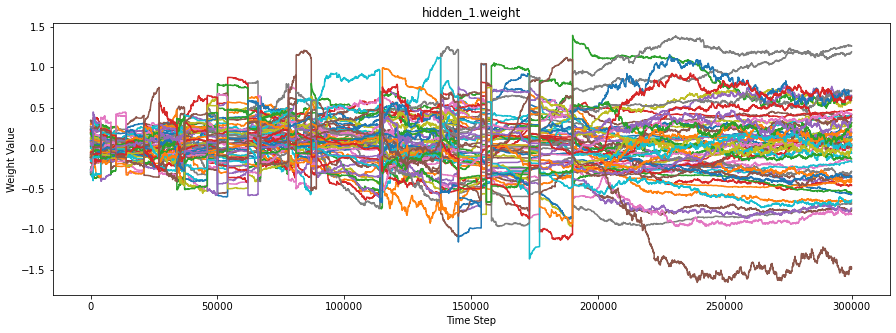

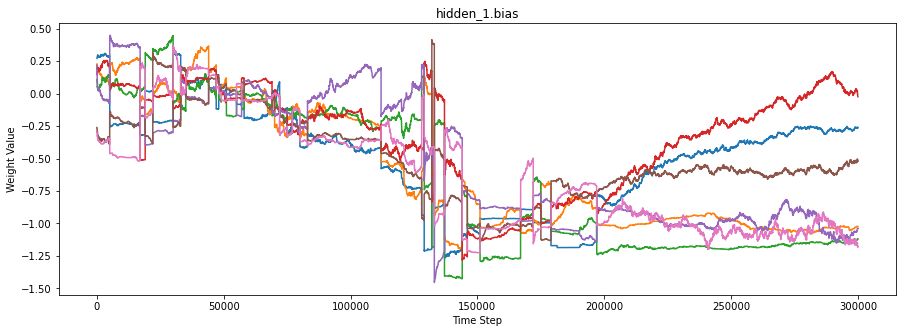

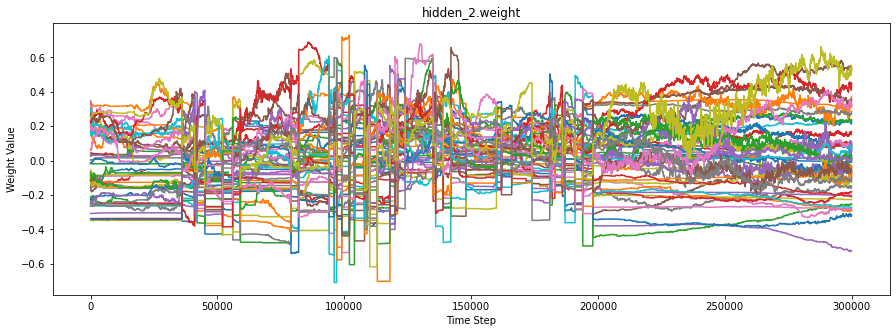

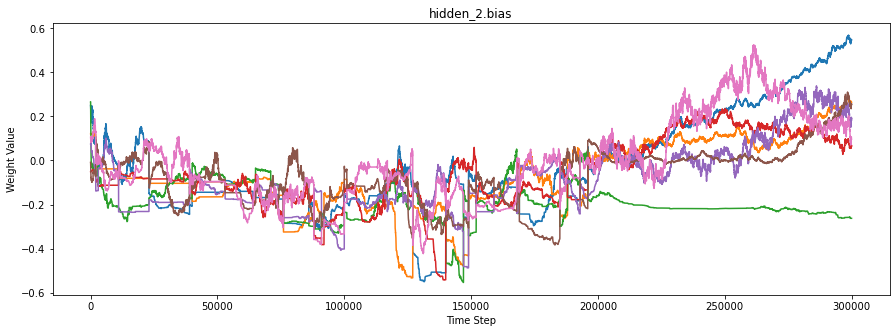

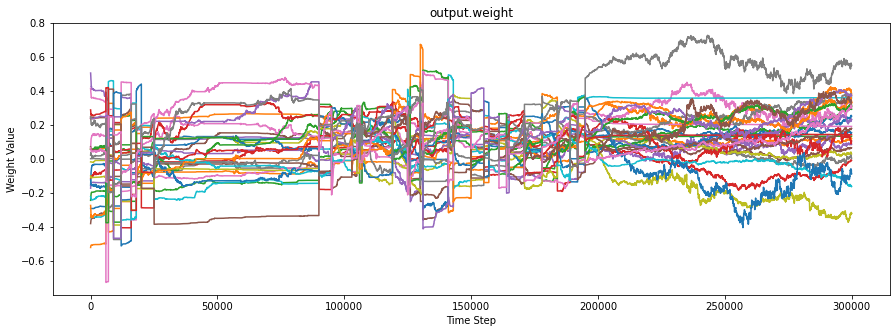

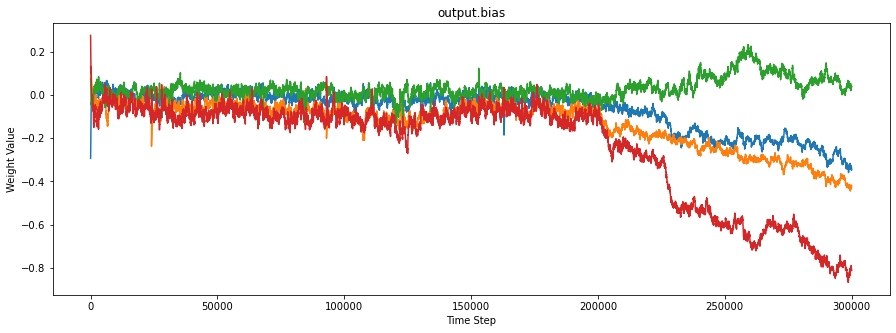

In [19]:
##x_range = (99998,100000) to view final weights
lab.graph(diff=0,graph_together = False, plot_size = (15,5) )

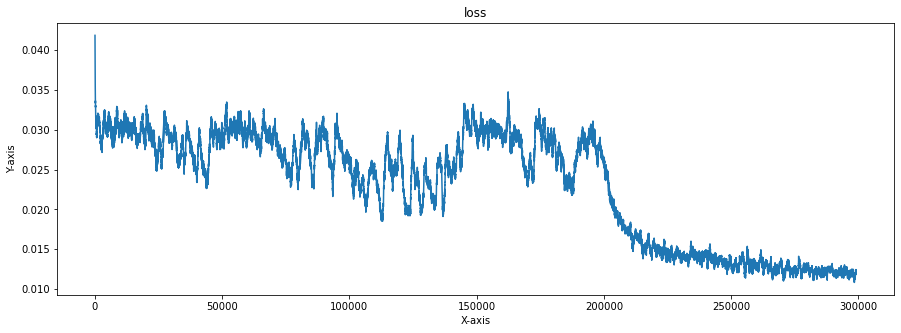

In [20]:
plot_line_graph(losses,window_size = 1000, plot_size = (15,5)) #window_size is the moving average window